# Train-Val-Test Split: Retina Fundus Gender Predictions
Run the following code to evaluate pretrained models on the Retina Fundus dataset for gender prediction.
The code will split the data into train, validation, and test sets, train the model on the train set, and evaluate the model on the validation and test sets.

Ensembling is also performed on the models to improve the performance.

Visualizations for trianing history are provided. 

## Imports / Installs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install torcheval
!pip install torchmetrics
!pip install xgboost

In [ ]:
import random
import timm
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import numpy as np
import random
import pickle
from torcheval.metrics import BinaryAccuracy
from torchmetrics import AUROC
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from itertools import combinations

## Model Training / Testing

In [ ]:
# Hyperparameters
num_classes = 1
lr = 0.0001
n_epochs = 15
batch_size = 32
batch_size_test = 32
RANDOM_SEED = 1839
pretrained = True

# Model selection
densenet_model = 'densenet121.tv_in1k'
resnet_model = 'resnet152'
resnetbit_model = 'resnetv2_50x1_bit.goog_in21k'
inception_model = 'inception_v3.tv_in1k'
vgg_model = 'vgg16.tv_in1k'
xception_model = 'xception41.tf_in1k'
maxvit_model = 'maxvit_nano_rw_256.sw_in1k'

# Dataset paths
dataset_path = "/content/drive/MyDrive/CS 163/processed_data/not_normal_256"
train_set_path = os.path.join(dataset_path, 'training')
validation_set_path = os.path.join(dataset_path, 'validation')
test_set_path = os.path.join(dataset_path, 'testing')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure dataset
class CustomDataset(Dataset):
    '''
    Custom dataset class to load data from pickle files.
    Meant for training and validation sets.
    '''
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []

        # Preprocessing
        self.transform = transforms.Compose([
            transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.3),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomEqualize(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # values for imagenet
        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                self.data.extend(pickle.load(f))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(int(data_point['label'] == 'Female'), dtype=torch.float)
        additional_info = data_point['additional_info']
        return image, label, additional_info

# This one doesn't have data augmentation, has the same normalization as CustomDataset
class CustomDatasetTest(Dataset):
    '''
    Custom dataset class to load data from pickle files.
    Meant for testing set, as it doesn't have data augmentation.
    '''
    def __init__(self, pickle_dir):
        self.pickle_files = [f for f in os.listdir(pickle_dir) if f.endswith('pickle') and not f.startswith('.')]
        self.data = []
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # values for imagenet
        ])

        for pickle_file in self.pickle_files:
            with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
                self.data.extend(pickle.load(f))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        image = data_point['image']
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(int(data_point['label'] == 'Female'), dtype=torch.float)
        additional_info = data_point['additional_info']
        return image, label, additional_info


def set_seed(RANDOM_SEED):
    torch.manual_seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.bexnchmark = False
    torch.backends.cudnn.deterministic = True


set_seed(RANDOM_SEED)

# create model and dataset, dataloader
models = [timm.create_model(model, pretrained=pretrained, num_classes=num_classes).to(device) for model in [maxvit_model, xception_model, resnet_model, resnetbit_model, densenet_model, inception_model]]
model_names = ['maxvit', 'xception', 'resnet152', 'ResnetBiT', 'Densenet', 'InceptionV3']

dataset_train = CustomDataset(train_set_path)
dataset_validation = CustomDatasetTest(validation_set_path)
dataset_test = CustomDatasetTest(test_set_path)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dataloader_validation = DataLoader(dataset_validation, batch_size=batch_size_test, shuffle=False, drop_last=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, drop_last=False)

In [ ]:
# Get the number of samples in each dataset
num_samples_train = len(dataloader_train.dataset)
num_samples_test = len(dataloader_test.dataset)
num_samples_val = len(dataloader_validation.dataset)
print(num_samples_train, num_samples_test, num_samples_val)

3750 628 620


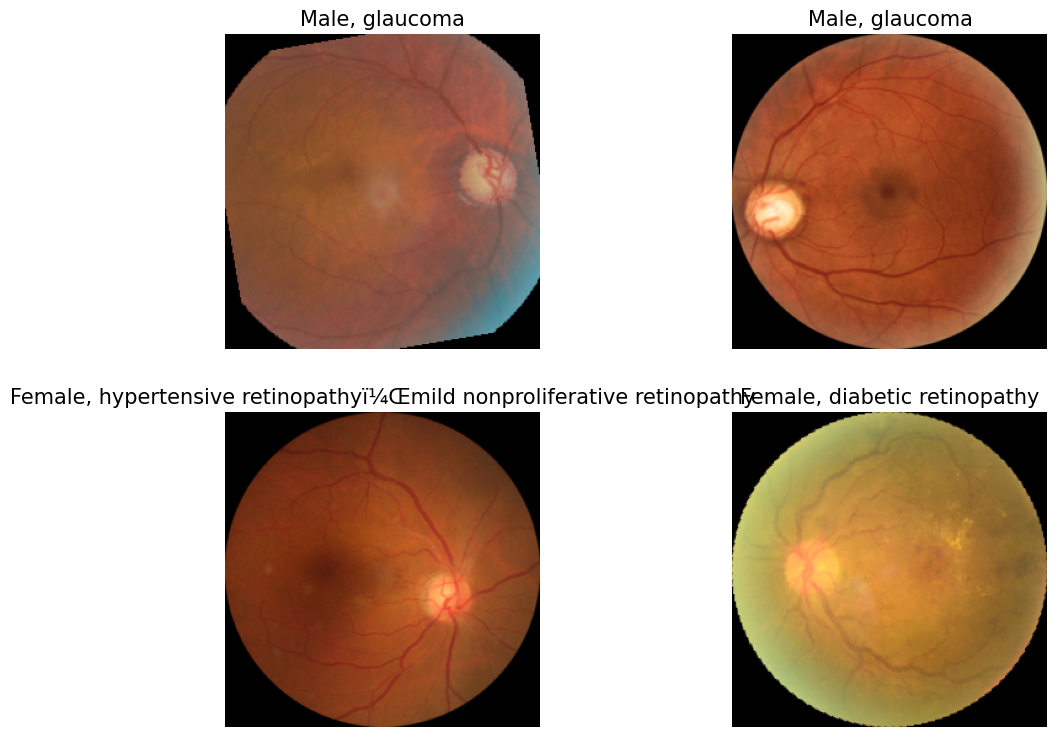

In [ ]:
def visualize_samples(dataloader, num_images=8, save_path="disease_retina_examples.png"):
    '''
    Visualize samples from the dataloader.
    '''
    images, labels, additional_info = next(iter(dataloader))

    male_images = [(img, info) for img, label, info in zip(images, labels, additional_info["diagnostic"]) if label == 0]
    female_images = [(img, info) for img, label, info in zip(images, labels, additional_info["diagnostic"]) if label == 1]

    num_per_gender = num_images // 2
    male_images = male_images[:num_per_gender]
    female_images = female_images[:num_per_gender]

    plt.figure(figsize=(12, 9))

    # Display male images in the first row
    for i, (image, diag_info) in enumerate(male_images):
        ax = plt.subplot(2, num_per_gender, i + 1)
        image = image.numpy().transpose((1, 2, 0)).clip(0, 1)
        plt.imshow(image)
        plt.title(f"Male, {diag_info}", size=15)
        plt.axis("off")

    # Display female images in the second row
    for i, (image, diag_info) in enumerate(female_images):
        ax = plt.subplot(2, num_per_gender, num_per_gender + i + 1)
        image = image.numpy().transpose((1, 2, 0)).clip(0, 1)
        plt.imshow(image)
        plt.title(f"Female, {diag_info}", size=15)
        plt.axis("off")

    plt.savefig(save_path)
    plt.show()

visualize_samples(dataloader_train, num_images=4)


In [ ]:
# Train and Validation functions

def train(dataloader_train, model, loss_fn, optimizer, device):
    '''
    Train the model on the training set.
    AUC and accuracy are printed after each epoch.
    '''
    model.train()

    running_loss = 0.0
    accuracy_metric = BinaryAccuracy(threshold=0.5)
    auc_metric = AUROC(task = 'binary')  # For binary classification AUC

    for _, (images, labels, additional_info) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(images).sigmoid().squeeze(1)  # Ensure output is probability-like
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update metrics for each batch
        accuracy_metric.update(predictions, labels)
        auc_metric.update(predictions, labels)

    loss_of_epoch = running_loss / len(dataloader_train)
    accuracy = accuracy_metric.compute().item()  # Compute accuracy after all batches
    auc_score = auc_metric.compute().item()  # Compute AUC after all batches

    print(f'Train Loss: {loss_of_epoch:.4f} \t Train Accuracy: {accuracy:.2f} \t Train AUC: {auc_score:.4f}')

    # Reset metrics for next epoch
    accuracy_metric.reset()
    auc_metric.reset()

    return loss_of_epoch, accuracy, auc_score


def validate(dataloader_validation, model, loss_fn, device):
    '''
    Standard validation loop for a single epoch.
    AUC and accuracy are printed after each epoch.
    '''
    model.eval()

    running_loss = 0.0
    accuracy_metric = BinaryAccuracy(threshold=0.5)
    auc_metric = AUROC(task = 'binary')  # For binary classification AUC

    with torch.no_grad():
        for _, (images, labels, _) in enumerate(dataloader_validation):
            images, labels = images.to(device), labels.to(device)

            prediction = model(images).sigmoid().squeeze(1)  # Ensure output is probability-like
            loss = loss_fn(prediction, labels)

            running_loss += loss.item()

            accuracy_metric.update(prediction, labels)
            auc_metric.update(prediction, labels)

    loss_of_epoch = running_loss / len(dataloader_validation)
    accuracy = accuracy_metric.compute().item()
    auc_score = auc_metric.compute().item()  # Compute AUC after all batches

    print(f'Val Loss: {loss_of_epoch:.4f} \t Val Accuracy: {accuracy:.3f} \t Val AUC: {auc_score:.4f}')

    # Reset metrics for next epoch
    accuracy_metric.reset()
    auc_metric.reset()

    return loss_of_epoch, accuracy, auc_score

In [ ]:
# Training loop
train_loss_all, train_acc_all, train_auc_all = list(), list(), list()
val_loss_all, val_acc_all, val_auc_all = list(), list(), list()
trained_models = []

for i, training_model in enumerate(models):
    print(f'MODEL {model_names[i]}')
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(training_model.parameters(), betas=(0.9, 0.999), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    print("Starting training...")

    train_loss_all.append(list())
    train_acc_all.append(list())
    train_auc_all.append(list())
    val_loss_all.append(list())
    val_acc_all.append(list())
    val_auc_all.append(list())

    for epoch in range(n_epochs):
        print(f'\nEpoch {epoch+1}\n{"-"*28}')

        loss_training, accuracy_training, auc_training = train(dataloader_train, training_model, loss_fn, optimizer, device)
        loss_validation, accuracy_validation, auc_validation = validate(dataloader_validation, training_model, loss_fn, device)

        train_loss_all[-1].append(loss_training)
        train_acc_all[-1].append(accuracy_training)
        train_auc_all[-1].append(auc_training)

        val_loss_all[-1].append(loss_validation)
        val_acc_all[-1].append(accuracy_validation)
        val_auc_all[-1].append(auc_validation)

        scheduler.step()

    trained_models.append(training_model)

MODEL maxvit
Starting training...

Epoch 1
----------------------------
Train Loss: 0.6971 	 Train Accuracy: 0.52 	 Train AUC: 0.5107
Val Loss: 0.6839 	 Val Accuracy: 0.581 	 Val AUC: 0.5874

Epoch 2
----------------------------
Train Loss: 0.6898 	 Train Accuracy: 0.54 	 Train AUC: 0.5309
Val Loss: 0.6782 	 Val Accuracy: 0.560 	 Val AUC: 0.6109

Epoch 3
----------------------------
Train Loss: 0.6837 	 Train Accuracy: 0.56 	 Train AUC: 0.5652
Val Loss: 0.7064 	 Val Accuracy: 0.547 	 Val AUC: 0.5905

Epoch 4
----------------------------
Train Loss: 0.6804 	 Train Accuracy: 0.56 	 Train AUC: 0.5806
Val Loss: 0.6918 	 Val Accuracy: 0.563 	 Val AUC: 0.5667

Epoch 5
----------------------------
Train Loss: 0.6779 	 Train Accuracy: 0.57 	 Train AUC: 0.5908
Val Loss: 0.6837 	 Val Accuracy: 0.571 	 Val AUC: 0.5723

Epoch 6
----------------------------
Train Loss: 0.6700 	 Train Accuracy: 0.59 	 Train AUC: 0.6163
Val Loss: 0.7030 	 Val Accuracy: 0.523 	 Val AUC: 0.5631

Epoch 7
---------------

## Average Ensembling

In [ ]:
def ensemble_predict(models, dataloader, device):
    '''
    Collect predictions from each model and average them for ensembling
    '''
    all_predictions = []
    with torch.no_grad():
        for images, _, _ in dataloader:
            images = images.to(device)
            # Collect predictions from each model
            predictions = [model(images).sigmoid().squeeze(1) for model in models]
            # Average predictions for ensembling
            ensemble_pred = torch.mean(torch.stack(predictions), dim=0)
            all_predictions.append(ensemble_pred.cpu().numpy())

    return np.concatenate(all_predictions)

In [ ]:
# Testing the ensemble on the test set
print("Starting testing on the test set using ensembling:")

# Calculate accuracy and AUC for the ensemble
y_true = []
y_pred = []

for _, labels, _ in dataloader_test:
    y_true.extend(labels.cpu().numpy())  # Assuming your labels are in the correct format
y_true = np.array(y_true)

for r in range(1, len(trained_models) + 1):  # r is the size of the subset
    for model_indices in combinations(range(len(trained_models)), r):
        model_subset = [trained_models[i] for i in model_indices]
        subset_names = [model_names[i] for i in model_indices]

        print(f'Trying subset: {subset_names}')
        ensemble_predictions = ensemble_predict(model_subset, dataloader_test, device)
        binary_predictions = (ensemble_predictions > 0.5).astype(int)

        accuracy_test = accuracy_score(y_true, binary_predictions)
        auc_test = roc_auc_score(y_true, ensemble_predictions)

        print(f'Subset Size: {r} \t Test Accuracy: {accuracy_test:.4f} \t Test AUC: {auc_test:.4f}')
        print("-" * 50)

Starting testing on the test set using ensembling:
Trying subset: ['maxvit']
Subset Size: 1 	 Test Accuracy: 0.6364 	 Test AUC: 0.6859
--------------------------------------------------
Trying subset: ['xception']
Subset Size: 1 	 Test Accuracy: 0.6102 	 Test AUC: 0.6485
--------------------------------------------------
Trying subset: ['resnet152']
Subset Size: 1 	 Test Accuracy: 0.6045 	 Test AUC: 0.6382
--------------------------------------------------
Trying subset: ['ResnetBiT']
Subset Size: 1 	 Test Accuracy: 0.6205 	 Test AUC: 0.6555
--------------------------------------------------
Trying subset: ['Densenet']
Subset Size: 1 	 Test Accuracy: 0.6205 	 Test AUC: 0.6512
--------------------------------------------------
Trying subset: ['InceptionV3']
Subset Size: 1 	 Test Accuracy: 0.6148 	 Test AUC: 0.6383
--------------------------------------------------
Trying subset: ['maxvit', 'xception']
Subset Size: 2 	 Test Accuracy: 0.6386 	 Test AUC: 0.6854
----------------------------

In [ ]:
# Testing the ensemble on the validation set
print("Starting testing on the test set using ensembling:")

# Calculate accuracy and AUC for the ensemble
y_true = []
y_pred = []

for _, labels, _ in dataloader_validation:
    y_true.extend(labels.cpu().numpy())
y_true = np.array(y_true)

for r in range(1, len(trained_models) + 1):  # r is the size of the subset
    for model_indices in combinations(range(len(trained_models)), r):
        model_subset = [trained_models[i] for i in model_indices]
        subset_names = [model_names[i] for i in model_indices]

        print(f'Trying subset: {subset_names}')
        ensemble_predictions = ensemble_predict(model_subset, dataloader_validation, device)
        binary_predictions = (ensemble_predictions > 0.5).astype(int)

        accuracy_test = accuracy_score(y_true, binary_predictions)
        auc_test = roc_auc_score(y_true, ensemble_predictions)

        print(f'Val Accuracy: {accuracy_test:.4f} \t Val AUC: {auc_test:.4f}')
        print("-" * 50)

Starting testing on the test set using ensembling:
Trying subset: ['maxvit']
Val Accuracy: 0.6313 	 Val AUC: 0.6937
--------------------------------------------------
Trying subset: ['xception']
Val Accuracy: 0.6336 	 Val AUC: 0.6715
--------------------------------------------------
Trying subset: ['resnet152']
Val Accuracy: 0.6025 	 Val AUC: 0.6397
--------------------------------------------------
Trying subset: ['ResnetBiT']
Val Accuracy: 0.6417 	 Val AUC: 0.6854
--------------------------------------------------
Trying subset: ['Densenet']
Val Accuracy: 0.6025 	 Val AUC: 0.6438
--------------------------------------------------
Trying subset: ['InceptionV3']
Val Accuracy: 0.6094 	 Val AUC: 0.6553
--------------------------------------------------
Trying subset: ['maxvit', 'xception']
Val Accuracy: 0.6486 	 Val AUC: 0.7040
--------------------------------------------------
Trying subset: ['maxvit', 'resnet152']
Val Accuracy: 0.6406 	 Val AUC: 0.6870
--------------------------------

## Stacking Ensembling

In [ ]:
# Use LogisticRegression as ensembling meta-learner
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Function to collect base model predictions
def get_base_model_predictions(models, dataloader, device):
    base_model_predictions = []

    for model in models:
        model.eval()
        predictions = []

        with torch.no_grad():
            for inputs, _, _ in dataloader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                predictions.append(outputs.cpu().numpy())

        base_model_predictions.append(np.concatenate(predictions))

    # Stack base model predictions as features for the meta-model
    stacked_predictions = np.column_stack(base_model_predictions)
    return stacked_predictions

# Collect the true labels from the test set
y_true_test = []
for _, labels, _ in dataloader_test:
    y_true_test.extend(labels.cpu().numpy())
y_true_test = np.array(y_true_test)

y_true_train = []
for _, labels, _ in dataloader_validation:
    y_true_train.extend(labels.cpu().numpy())
y_true_train = np.array(y_true_train)

# Get base model predictions on the test set
print("Collecting base model predictions...")
base_predictions_train = get_base_model_predictions(trained_models, dataloader_validation, device)  # Use training data for meta-model training
base_predictions_test = get_base_model_predictions(trained_models, dataloader_test, device)    # Use test data for evaluation

# Train a meta-model (logistic regression) on the predictions of the base models
print("Training meta-model...")
meta_model = LogisticRegression()
meta_model.fit(base_predictions_train, y_true_train[:])  # Train using a subset if needed

# Use the meta-model to predict on the test set
print("Making final predictions with meta-model...")
ensemble_predictions = meta_model.predict_proba(base_predictions_test)[:, 1]  # Get the probability for class 1
binary_predictions = (ensemble_predictions > 0.5).astype(int)

# Calculate accuracy and AUC for the stacked ensemble
accuracy_test = accuracy_score(y_true_test, binary_predictions)
auc_test = roc_auc_score(y_true_test, ensemble_predictions)

print(f'Stacked Ensemble Test Accuracy: {accuracy_test:.4f} \t Test AUC: {auc_test:.4f}')

Training meta-model...
Making final predictions with meta-model...
Stacked Ensemble Test Accuracy: 0.6420 	 Test AUC: 0.6870


## Plotting

Testing Model maxvit on the test set
Val Loss: 0.7578 	 Val Accuracy: 0.636 	 Val AUC: 0.6859
Testing Model xception on the test set
Val Loss: 1.1608 	 Val Accuracy: 0.610 	 Val AUC: 0.6485
Testing Model resnet152 on the test set
Val Loss: 0.7231 	 Val Accuracy: 0.605 	 Val AUC: 0.6382
Testing Model ResnetBiT on the test set
Val Loss: 0.9327 	 Val Accuracy: 0.620 	 Val AUC: 0.6555
Testing Model Densenet on the test set
Val Loss: 0.9027 	 Val Accuracy: 0.620 	 Val AUC: 0.6512
Testing Model InceptionV3 on the test set
Val Loss: 1.0252 	 Val Accuracy: 0.615 	 Val AUC: 0.6383


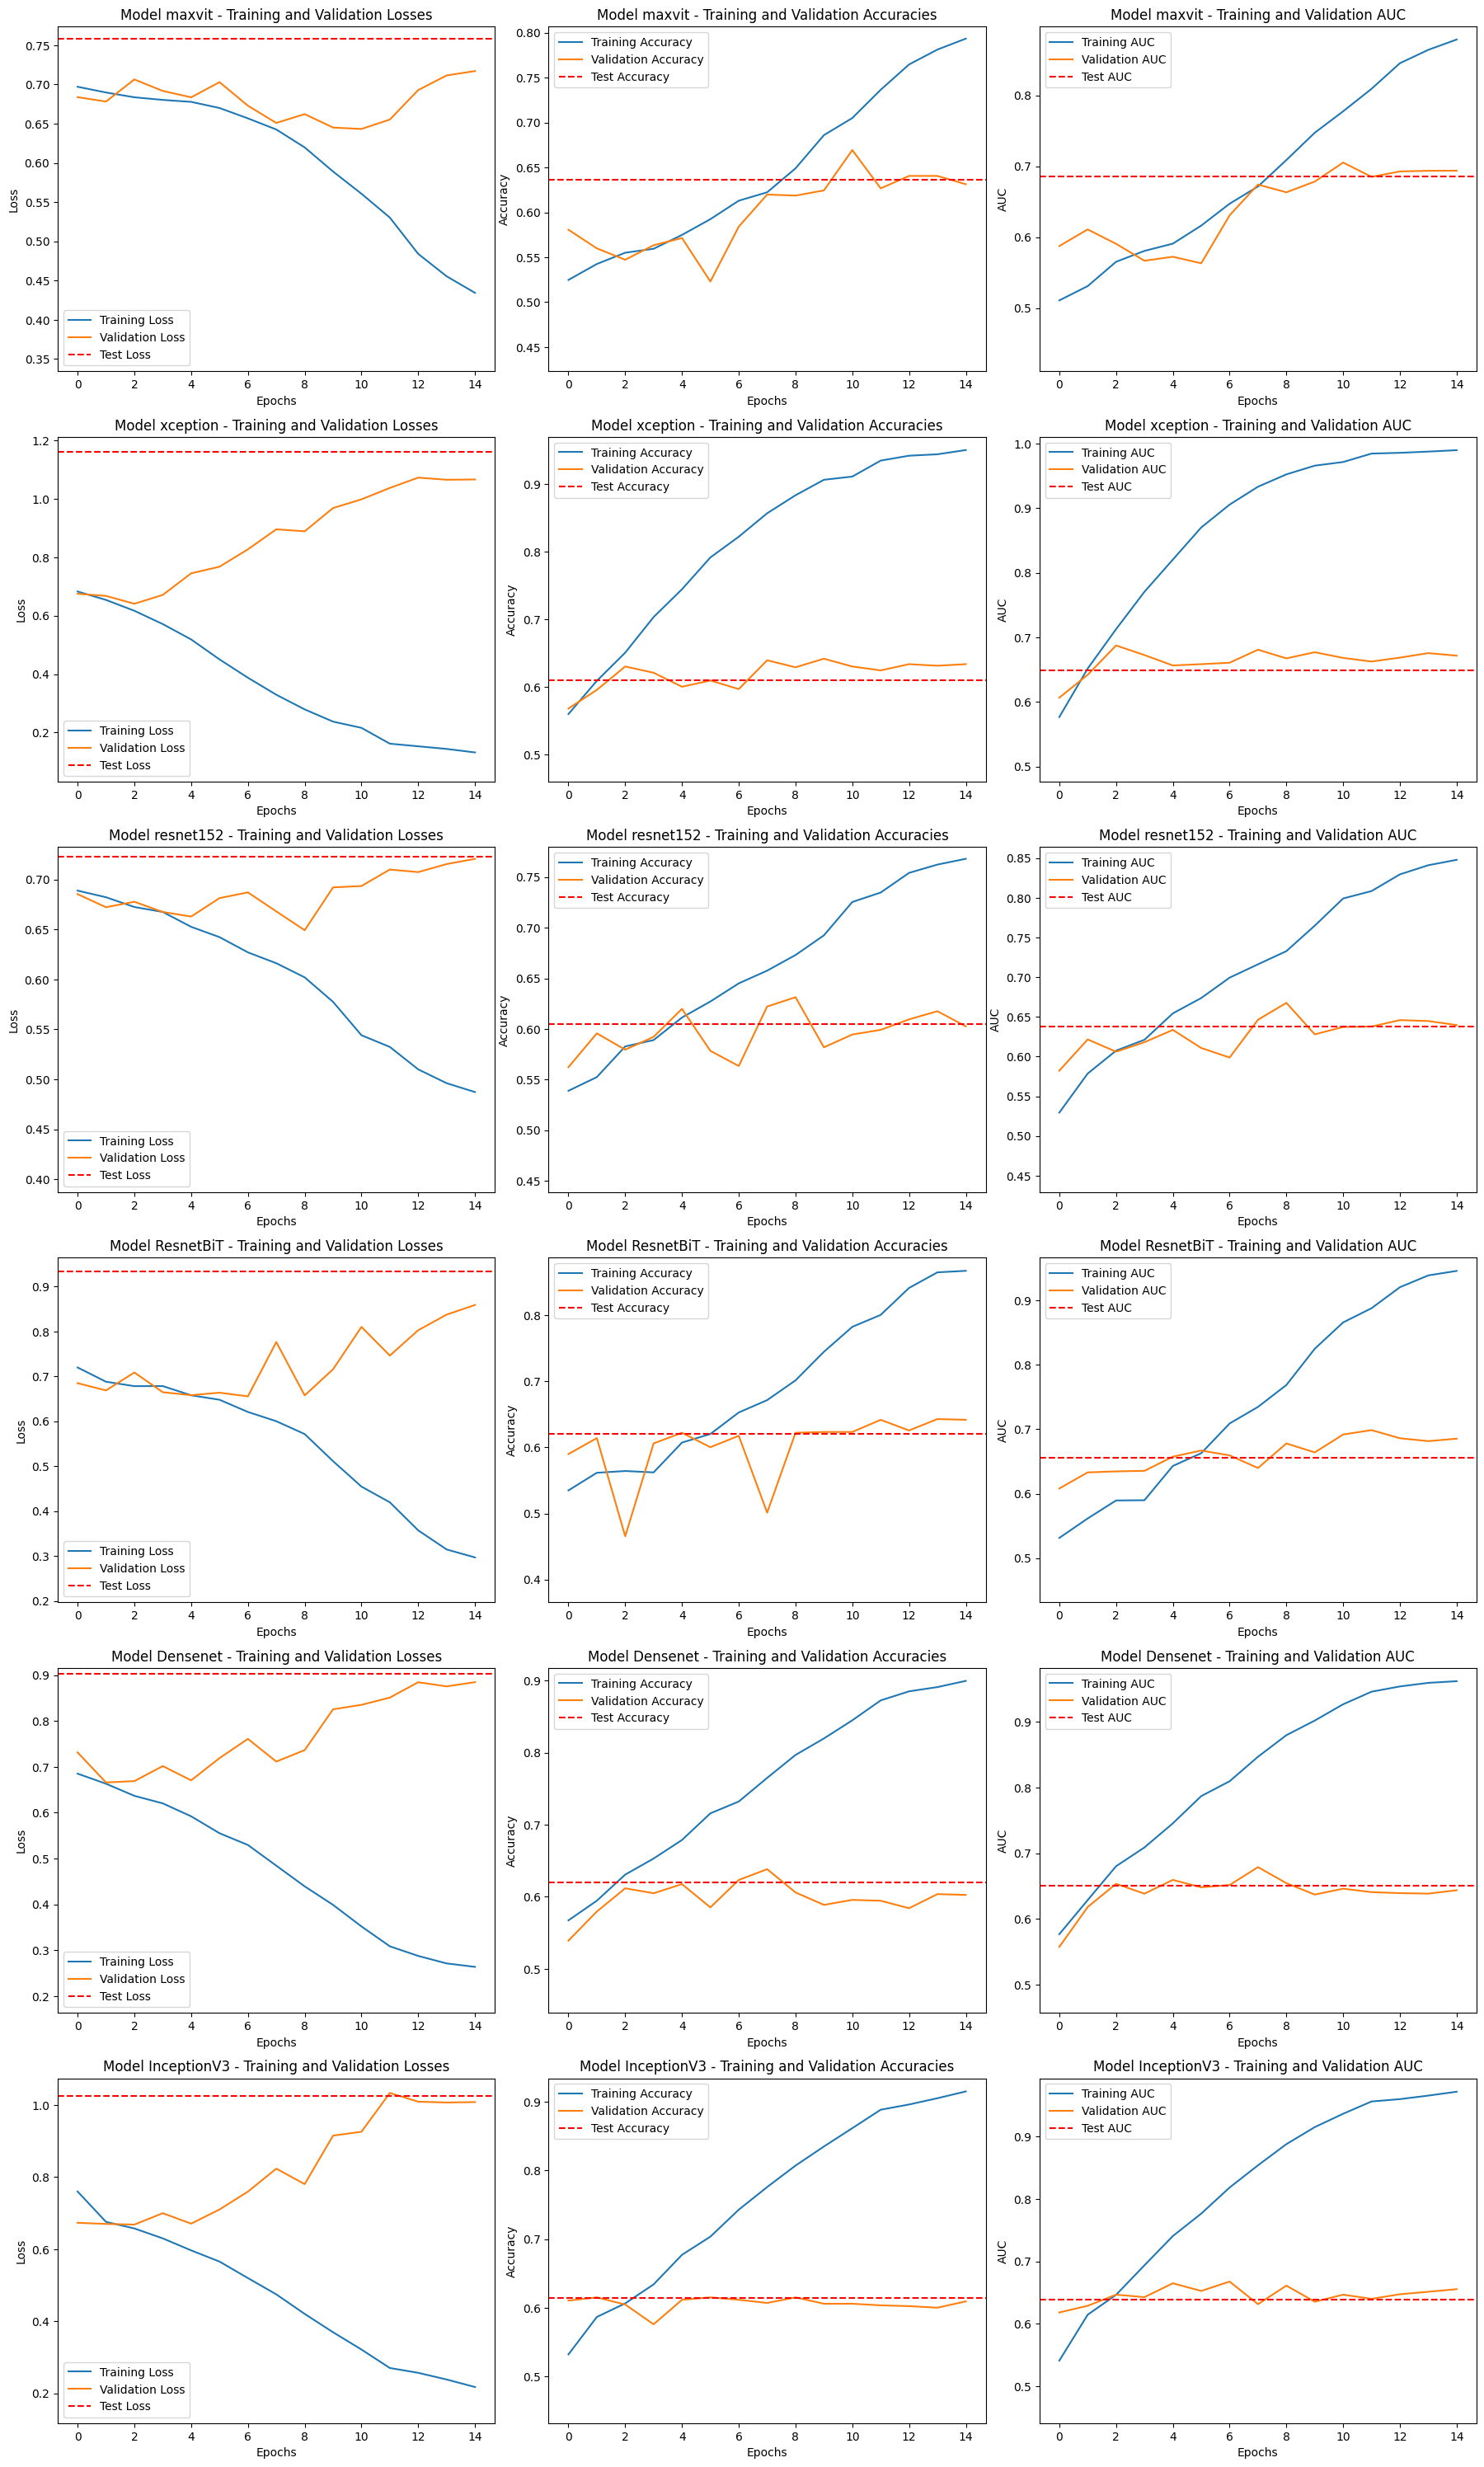

In [ ]:
# Plotting the training/validation curves for each model separately

n_models = len(trained_models)
fig, axs = plt.subplots(n_models, 3, figsize=(18, 5 * n_models))

# Loop through each model and plot its corresponding data
for idx, (train_loss, val_loss, train_acc, val_acc, train_auc, val_auc) in enumerate(
        zip(train_loss_all, val_loss_all, train_acc_all, val_acc_all, train_auc_all, val_auc_all)):

    # Test results for the current model
    print(f"Testing Model {model_names[idx]} on the test set")
    loss_test, accuracy_test, auc_test = validate(dataloader_test, trained_models[idx], loss_fn, device)

    # If only one model, axs won't be 2D, so we convert it to 2D for uniform access
    model_axs = axs if n_models == 1 else axs[idx]

    # Plot for Training and Validation Losses
    model_axs[0].set_title(f"Model {model_names[idx]} - Training and Validation Losses")
    model_axs[0].plot(train_loss, label="Training Loss")
    model_axs[0].plot(val_loss, label="Validation Loss")
    model_axs[0].axhline(y=loss_test, color='r', linestyle='--', label="Test Loss")
    model_axs[0].set_ylim(ymin=min(min(train_loss), min(val_loss)) - 0.1)
    model_axs[0].set_xlabel("Epochs")
    model_axs[0].set_ylabel("Loss")
    model_axs[0].legend()

    # Plot for Accuracies
    model_axs[1].set_title(f"Model {model_names[idx]} - Training and Validation Accuracies")
    model_axs[1].plot(train_acc, label="Training Accuracy")
    model_axs[1].plot(val_acc, label="Validation Accuracy")
    model_axs[1].axhline(y=accuracy_test, color='r', linestyle='--', label="Test Accuracy")
    model_axs[1].set_ylim(ymin=min(min(train_acc), min(val_acc)) - 0.1)
    model_axs[1].set_xlabel("Epochs")
    model_axs[1].set_ylabel("Accuracy")
    model_axs[1].legend()

    # Plot for AUC
    model_axs[2].set_title(f"Model {model_names[idx]} - Training and Validation AUC")
    model_axs[2].plot(train_auc, label="Training AUC")
    model_axs[2].plot(val_auc, label="Validation AUC")
    model_axs[2].axhline(y=auc_test, color='r', linestyle='--', label="Test AUC")
    model_axs[2].set_ylim(ymin=min(min(train_auc), min(val_auc)) - 0.1)
    model_axs[2].set_xlabel("Epochs")
    model_axs[2].set_ylabel("AUC")
    model_axs[2].legend()

plt.subplots_adjust(hspace=1.5)

# Adjust layout to prevent overlapping
plt.tight_layout(pad = 1.0)
plt.savefig('full_training_curves.png')

# Show the plot
plt.show()